In [2]:
# import libraries
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import TomekLinks
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.metrics import make_scorer, accuracy_score #Import scikit-learn metrics module for accuracy calculation
from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV  # Randomized search on hyper parameters.
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
from pandas import set_option
plt.style.use('ggplot') # nice plots

from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold # for cross validation
from sklearn.model_selection import RandomizedSearchCV  # Randomized search on hyper parameters.
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import warnings
from sklearn.utils import resample
pd.set_option('display.max_columns', 1000)
%matplotlib inline 
import warnings; warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv('clean_data.csv')

In [3]:
df.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,hdi
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0.939
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0.939
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,0.961
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0.667
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0.939


In [4]:
#setting the target varibale to binary
df['no_show']=np.where(df['no_show']=='No',0,1)

In [5]:
df.columns

Index(['patient_id', 'appointment_id', 'gender', 'scheduled_day',
       'appointment_day', 'age', 'neighbourhood', 'scholarship',
       'hipertension', 'diabetes', 'alcoholism', 'handcap', 'sms_received',
       'no_show', 'hdi'],
      dtype='object')

In [6]:
df_patient = df

In [7]:
df_patient['patient_id'].astype('str')

0          29872499824296.0
1         558997776694438.0
2           4262962299951.0
3            867951213174.0
4           8841186448183.0
                ...        
110522      2572134369293.0
110523      3596266328735.0
110524     15576631729893.0
110525     92134931435557.0
110526    377511518121127.0
Name: patient_id, Length: 110527, dtype: object

features to engineer:

1. wait time = appointment day - scheduled day - chibz
2. generation = bins of age split into generation - tom
3. day of appointment = use datetime object to pull out day of week - chibz
4. at_risk = patients who have 2 of the 3 diseases - binary 1 is at risk, 0 is not - tom
5. by_season = appointment day broken down by season - tom
6. neighborhood dummies = one-hot encode neighbourhood column
7. need to examine and drop outliers
8. group by patients - chibz
9. then we could engineer appointment counts - chibz

In [10]:
## Converting the date information in string to datetime type:
df['scheduled_day'] = pd.to_datetime(df.scheduled_day)
df['appointment_day'] = pd.to_datetime(df.appointment_day)
## Creating a new column (attribute) containing just the scheduling time:
#df['schedule_time'] = df.scheduled_day.dt.time
## Normalizing the "Day" columns to keep just the date information (dropping the time info)
df['scheduled_day'] = df.scheduled_day.dt.normalize()
df['day_of_week']= df.appointment_day.dt.day_name()

### WAITING TIME

In [11]:
#waiting days
df['waiting_days'] = df['appointment_day'] - df['scheduled_day']


In [12]:
df['waiting_days'] = df.waiting_days.dt.days  #Extract just the day value from the full "timedelta" object

In [13]:
## Checking which instances were scheduled after the appointment:
df[df['waiting_days'] <0]

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,hdi,day_of_week,waiting_days
27033,7.839273e+12,5679978,M,2016-05-10 00:00:00+00:00,2016-05-09 00:00:00+00:00,38,RESISTÊNCIA,0,0,0,0,1,0,1,0.642,Monday,-1
55226,7.896294e+12,5715660,F,2016-05-18 00:00:00+00:00,2016-05-17 00:00:00+00:00,19,SANTO ANTÔNIO,0,0,0,0,1,0,1,0.645,Tuesday,-1
64175,2.425226e+13,5664962,F,2016-05-05 00:00:00+00:00,2016-05-04 00:00:00+00:00,22,CONSOLAÇÃO,0,0,0,0,0,0,1,0.706,Wednesday,-1
71533,9.982316e+14,5686628,F,2016-05-11 00:00:00+00:00,2016-05-05 00:00:00+00:00,81,SANTO ANTÔNIO,0,0,0,0,0,0,1,0.645,Thursday,-6
72362,3.787482e+12,5655637,M,2016-05-04 00:00:00+00:00,2016-05-03 00:00:00+00:00,7,TABUAZEIRO,0,0,0,0,0,0,1,0.953,Tuesday,-1


In [14]:
## Recording the inconsistent instances index 
dropIx = df[df['waiting_days'] < 0].index
## Dropping these instances from the dataset:
df.drop(dropIx, inplace=True)

In [15]:
## Grouping by the 'WaitingDays' and 'No_show' values:
waitingdays = df.groupby(by=['waiting_days','no_show'])

In [16]:
waitingdays = waitingdays.count()['patient_id'].unstack()

In [17]:
waitingdays.fillna(value=0, inplace=True)
waitingdays.reset_index(drop=False, inplace=True)
waitingdays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   waiting_days  129 non-null    int64  
 1   0             129 non-null    float64
 2   1             129 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.1 KB


In [18]:
waitingdays

no_show,waiting_days,0,1
0,0,36771.0,1792.0
1,1,4100.0,1113.0
2,2,5123.0,1602.0
3,3,2093.0,644.0
4,4,4059.0,1231.0
...,...,...,...
124,155,4.0,6.0
125,162,9.0,2.0
126,169,7.0,1.0
127,176,10.0,6.0


### WAITING CATEGORIES

In [19]:
## Defining the categories label:
categories = pd.Series(['same day: 0', 'short: 1-3', 'week: 4-7', 'fortnight: 8-15', 'month: 16-30', 'quarter: 31-90', 'semester: 91-180', 'long: 181-10000'])




In [20]:
## Applying these categories both to the auxiliary and to the working datasets:
waitingdays['waiting_days'] = pd.cut(waitingdays.waiting_days, bins = [-1,0,3,7,15,30,90,180, 10000], labels=categories)
df['waiting_categories'] = pd.cut(df.waiting_days, bins = [-1,0,3,7,15,30,90,180, 10000], labels=categories)



In [21]:
## Grouping the dataset by the waiting categories, returning the sum of all instances:
waitingdays = waitingdays.groupby('waiting_days').sum()
## Creating a new attribute, "No-showing rate", relating how many patients did not show up against those who did.
waitingdays['no_showing_rate'] = (waitingdays[1]/ waitingdays[0])*100

In [22]:
waitingdays

no_show,0,1,no_showing_rate
waiting_days,,,
same day: 0,36771.0,1792.0,4.873406
short: 1-3,11316.0,3359.0,29.683634
week: 4-7,13097.0,4413.0,33.694739
fortnight: 8-15,9362.0,4166.0,44.499039
month: 16-30,10709.0,5159.0,48.174433
quarter: 31-90,6792.0,3369.0,49.602473
semester: 91-180,161.0,56.0,34.782609
long: 181-10000,0.0,0.0,NaN


In [64]:
eda_waitingDays = waitingdays.copy()  #Copying the dataframe from Section 2.3.3
eda_waitingDays.reset_index(drop=False, inplace=True)  #Making the index as a column in order to be plotted.
eda_waitingDays.drop(7, inplace=True)  #Droppping the last row, since it's empty.

## Adding new columns:
#Transforming the 'No-showing rate' into strings with the percentual values:
eda_waitingDays['no_show_percentual'] = eda_waitingDays['no_showing_rate'].apply(lambda x: '{0:.2f}%'.format(x))
#Multiplying the rate values by 500 times in order to be plotted in the same scale:
eda_waitingDays['no_showing_rate_(500x)'] = eda_waitingDays['no_showing_rate']*500

## Showing the adjusting dataframe:
eda_waitingDays


no_show,waiting_days,0,1,no_showing_rate,no_show_percentual,no_showing_rate_(500x)
0,same day: 0,36771.0,1792.0,4.873406,4.87%,2436.702836
1,short: 1-3,11316.0,3359.0,29.683634,29.68%,14841.816896
2,week: 4-7,13097.0,4413.0,33.694739,33.69%,16847.369627
3,fortnight: 8-15,9362.0,4166.0,44.499039,44.50%,22249.519333
4,month: 16-30,10709.0,5159.0,48.174433,48.17%,24087.216360
5,quarter: 31-90,6792.0,3369.0,49.602473,49.60%,24801.236749
6,semester: 91-180,161.0,56.0,34.782609,34.78%,17391.304348


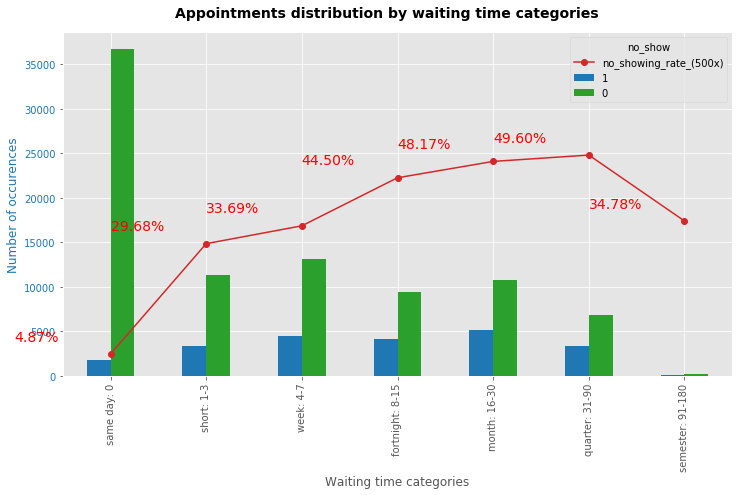

In [66]:
## Setting the graph parameters:
fig1, ax = plt.subplots(figsize=[12,6])  #Defines the graph window size
fig1.subplots_adjust(top=0.92)
plt.suptitle('Appointments distribution by waiting time categories', fontsize=14, fontweight='bold')

colors = ['tab:blue', 'tab:green', 'tab:red']  #Defines the colors to be used

ax.set_ylabel('Number of occurences', color=colors[0], fontsize=12)  #Set the y-axis color and label
ax.tick_params(axis='y', labelcolor=colors[0])

## Plotting the line chart:
eda_waitingDays[['waiting_days', 'no_showing_rate_(500x)']].plot(x='waiting_days', linestyle='-', marker='o', ax=ax, color=colors[2])
#Setting the line chart marker labels
x = ax.get_xticks()  #Getting the x-axis ticks to plot the label
for a,b,c in zip(x,eda_waitingDays['no_showing_rate_(500x)'], eda_waitingDays['no_show_percentual']):
    plt.text(a,b+1500,c, color='red', fontsize=14)
    
## Plotting the bar chart:
eda_waitingDays[['waiting_days', 1, 0]].plot(x='waiting_days', kind='bar', ax=ax, color=colors[0:2])

ax.set_xlabel('Waiting time categories', fontsize=12)  #Set the y-axis color and label

plt.show()


In [37]:
#made a count column to help with my groupby
df['cnt']=1

In [25]:
df.age.value_counts()

 0      3539
 1      2273
 52     1746
 49     1652
 53     1651
        ... 
 115       5
 100       4
 102       2
 99        1
-1         1
Name: age, Length: 104, dtype: int64

### Looking at the target variable (no_show/show)

In [42]:
print("NoShow and Show Count of Patients\n")
print(df.groupby(['no_show']).size())

print("\nNoShow and Show '%' of Patients\n")
show = df.groupby(['no_show']).size()[0]/(df.groupby(['no_show']).size()[0]+df.groupby(['no_show']).size()[1])
print("Percent of Patients who `Showed Up` => {:.2f}%".format(show*100))
noshow = df.groupby(['no_show']).size()[1]/(df.groupby(['no_show']).size()[0]+df.groupby(['no_show']).size()[1])
print("Percent of Patients who Did `Not Showed Up` => {:.2f}%".format(noshow*100))

NoShow and Show Count of Patients

no_show
0    88208
1    22314
dtype: int64

NoShow and Show '%' of Patients

Percent of Patients who `Showed Up` => 79.81%
Percent of Patients who Did `Not Showed Up` => 20.19%


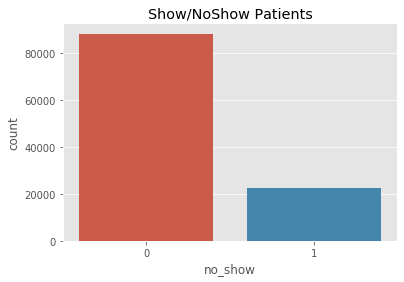

In [43]:
ax = sns.countplot(x=df.no_show, data=df)
ax.set_title("Show/NoShow Patients")
plt.show()


### GENDER

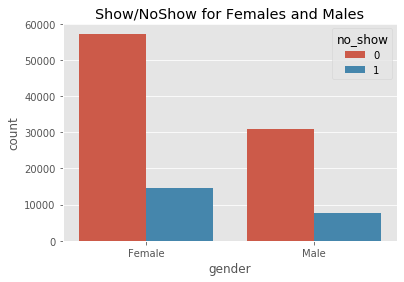

In [44]:
#a plot of no show and show count of both males and females

ax = sns.countplot(x=df.gender, hue=df.no_show, data=df)
ax.set_title("Show/NoShow for Females and Males")
x_ticks_labels=['Female', 'Male']
ax.set_xticklabels(x_ticks_labels)
plt.show()

### AGE

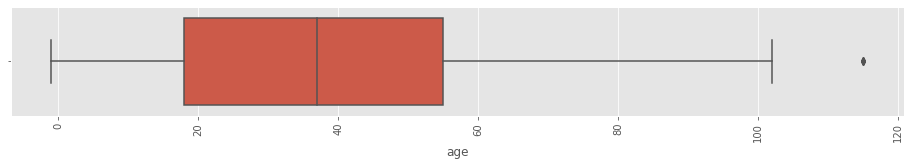

In [45]:
#age distribution plot
plt.figure(figsize=(16,2))
plt.xticks(rotation=90)
_ = sns.boxplot(x=df.age)

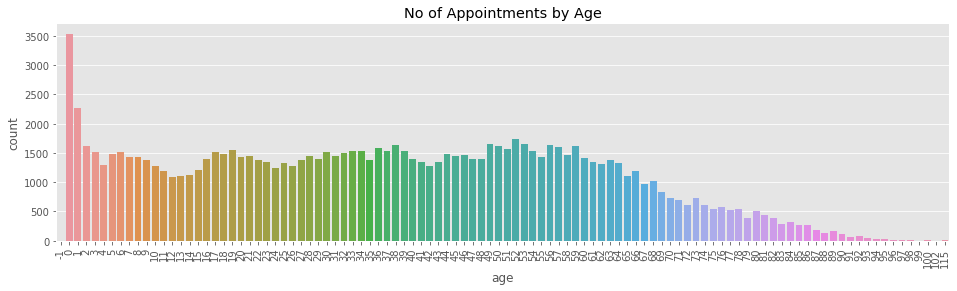

In [46]:
# appointments by age plot
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.age)
ax.set_title("No of Appointments by Age")
plt.show()

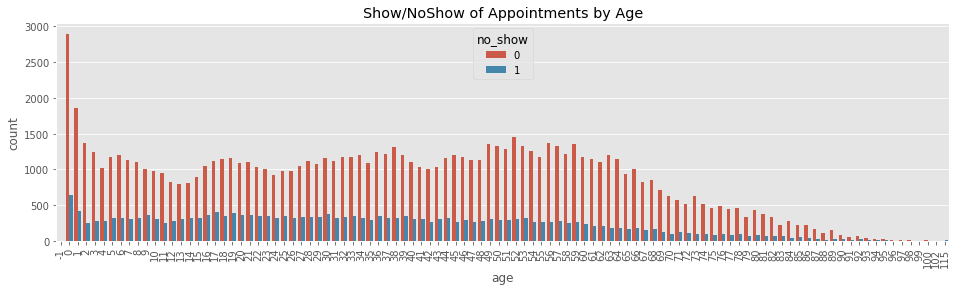

In [47]:
#no show and show accross age vs appointment count
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.age, hue=df.no_show)
ax.set_title("Show/NoShow of Appointments by Age")
plt.show()

In [48]:
df_age_ratio = df[df.no_show == 1].groupby(['age']).size()/df.groupby(['age']).size()

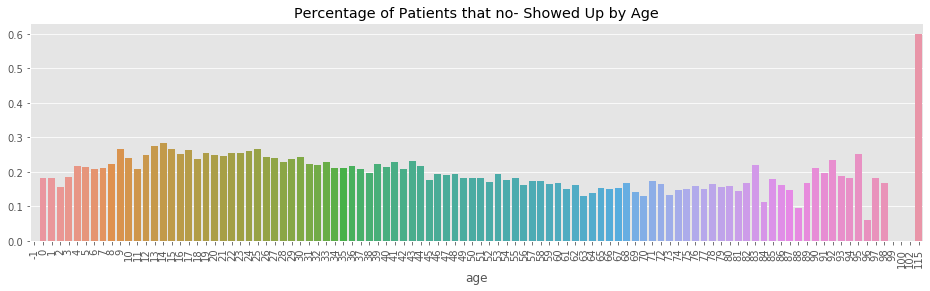

In [49]:

#rate of no shows accross the age distribution

plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.barplot(x=df_age_ratio.index, y=df_age_ratio)
ax.set_title("Percentage of Patients that no- Showed Up by Age")
plt.show()

Findings: No show rate seems to rise as one becomes a young adult but falls later as an older adult possibly becaue older adults have more need for medical checks hence don't miss out too much but later as the age increase further there is another rise possible because they are dependets again

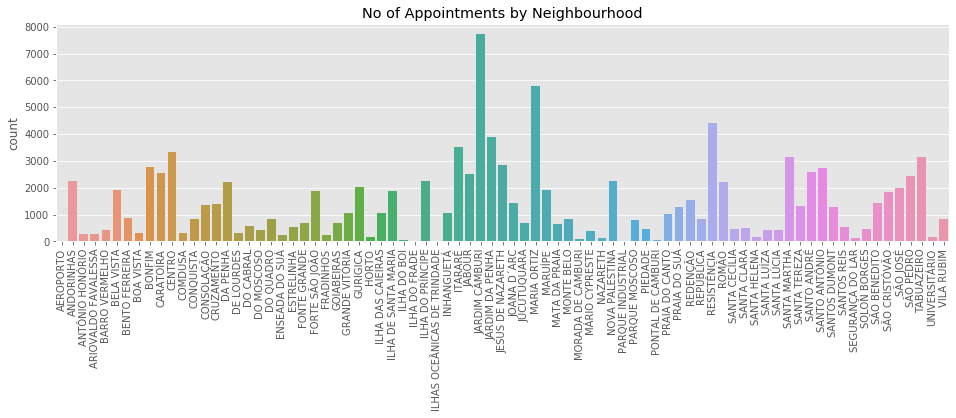

In [50]:

#appointment distrubtion across hoods
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=np.sort(df.neighbourhood))
ax.set_title("No of Appointments by Neighbourhood")
plt.show()

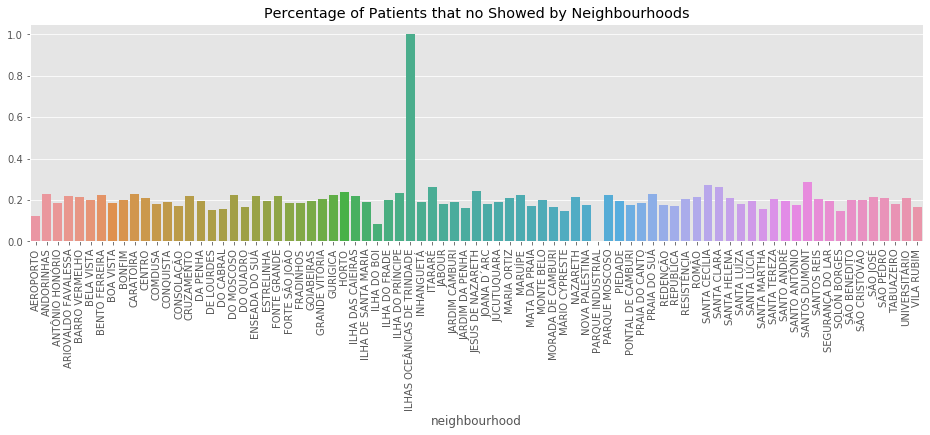

In [36]:
#ratio of no shows acccording to neighbourhood
df_hood_ratio = df[df.no_show == 1].groupby(['neighbourhood']).size()/df.groupby(['neighbourhood']).size()

plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.barplot(x=df_hood_ratio.index, y=df_hood_ratio)
ax.set_title("Percentage of Patients that no Showed by Neighbourhoods")
plt.show()

Findings:  The RATE OF NO SHOWS  accroos the neighbourhood are consistently about 20% except for a few outliers which are easily explained with the lack in volume of data in the area

### Scholarship

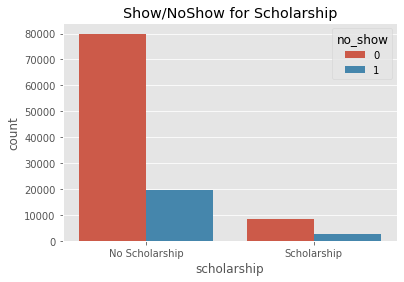

In [51]:
#count of no show and show 

ax = sns.countplot(x=df.scholarship, hue=df.no_show, data=df)
ax.set_title("Show/NoShow for Scholarship")
x_ticks_labels=['No Scholarship', 'Scholarship']
ax.set_xticklabels(x_ticks_labels)
plt.show()

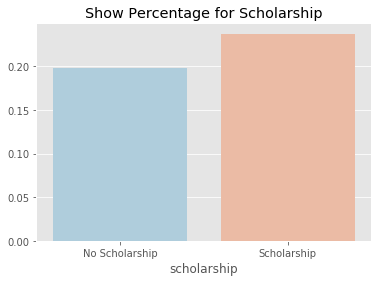

In [52]:
# The rate of no show of the two populations with and without Scholarship
df_s_ratio = df[df.no_show == 1].groupby(['scholarship']).size()/df.groupby(['scholarship']).size()
ax = sns.barplot(x=df_s_ratio.index, y=df_s_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for Scholarship")
x_ticks_labels=['No Scholarship', 'Scholarship']
ax.set_xticklabels(x_ticks_labels)
plt.show()

### STATS TEST for scholarship

NUll hypotesis: That the rate of noshows of at risk population = the rate of no show for not at risk population

Alternate Hypotesis: The rate of no show of people at risk is not equal to the rate of no shows for people at risk 

In [75]:
show=df[df['no_show']==0]
noshow=df[df['no_show']==1]

import statsmodels.api as sm
import numpy as np
import scipy.stats as stats
stats.ttest_ind(show['scholarship'], noshow['scholarship'])

Ttest_indResult(statistic=-9.70069768859156, pvalue=3.0562861231303697e-22)

We can rejct the null hypotesis, there is a significant difference in the rate of noshows for people at risk vs the rate of noshows for people not at risk.

Findings: We find that this infact is an important feature, and we can see that people who are at risk tend to make their appointments more often

### DAYS OF THE WEEK

In [49]:
week_key=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

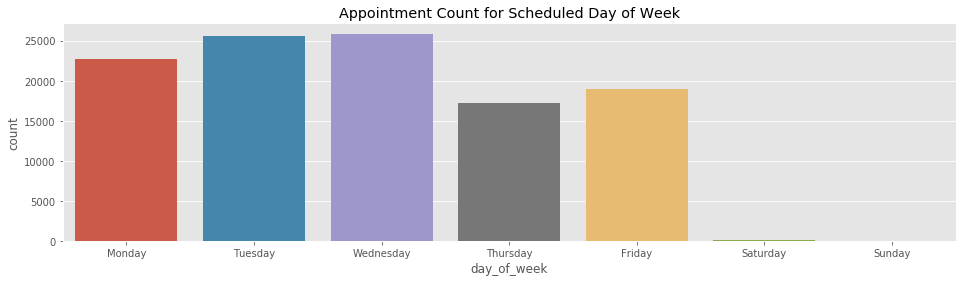

In [50]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df.day_of_week, order=week_key)
ax.set_title("Appointment Count for Scheduled Day of Week")
plt.show()

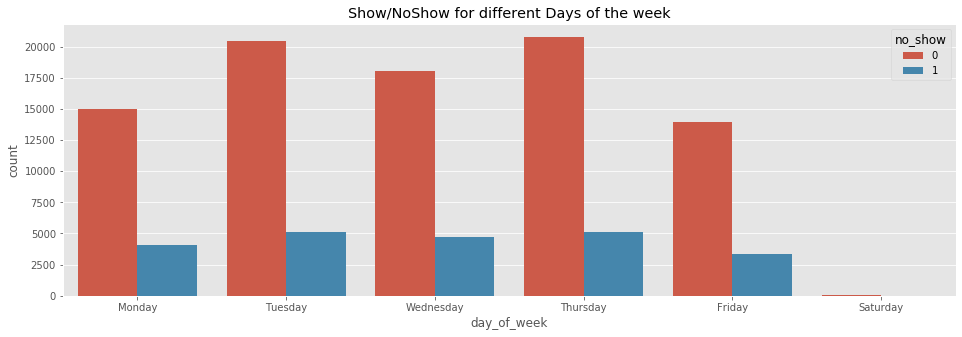

In [80]:
plt.subplots(figsize=[16,5])
ax = sns.countplot(x=df.day_of_week, hue=df.no_show, data=df)
ax.set_title("Show/NoShow for different Days of the week")
x_ticks_labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax.set_xticklabels(x_ticks_labels)
plt.show()

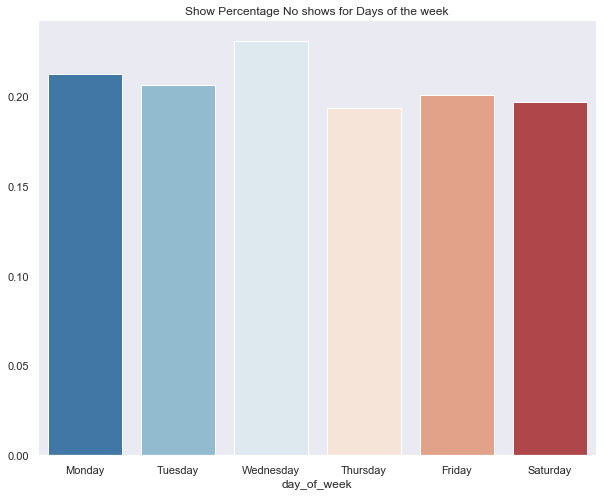

In [219]:
plt.subplots(figsize=[10,8])
df_w_ratio = df[df.no_show == 1].groupby(['day_of_week']).size()/df.groupby(['day_of_week']).size()
ax = sns.barplot(x=df_w_ratio.index, y=df_w_ratio, palette="RdBu_r")
ax.set_title("Show Percentage No shows for Days of the week")
x_ticks_labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax.set_xticklabels(x_ticks_labels)
plt.show()

### STATS TEST for days of the week

Null hypotesis : That the no show rates across the different days are equal
Alternate hypotesis : The no show rates across the different days are not equal

In [83]:
df_dow1 = df[df['day_of_week'] == 'Monday']
df_dow2 = df[df['day_of_week'] == 'Tuesday']
df_dow3 = df[df['day_of_week'] == 'Wednesday']
df_dow4 = df[df['day_of_week'] == 'Thursday']
df_dow5 = df[df['day_of_week'] == 'Friday']
df_dow6 = df[df['day_of_week'] == 'Saturday']


In [ ]:
week_key=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [84]:

df_dow = pd.DataFrame(columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])


df_dow['Monday'] = df_dow1.groupby('no_show')['no_show'].count()
df_dow['Tuesday'] = df_dow2.groupby('no_show')['no_show'].count()
df_dow['Wednesday'] = df_dow3.groupby('no_show')['no_show'].count()
df_dow['Thursday'] = df_dow4.groupby('no_show')['no_show'].count()
df_dow['Friday'] = df_dow5.groupby('no_show')['no_show'].count()
df_dow['Saturday'] = df_dow6.groupby('no_show')['no_show'].count()
df_dow.head()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
no_show,,,,,,
0,18025,20488,20774,13909,14982,30
1,4689,5150,5092,3337,4037,9


In [85]:
df_dow.fillna(value=0, inplace=True)
df_dow.reset_index(drop=False, inplace=True)
df_dow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   no_show    2 non-null      int64
 1   Monday     2 non-null      int64
 2   Tuesday    2 non-null      int64
 3   Wednesday  2 non-null      int64
 4   Thursday   2 non-null      int64
 5   Friday     2 non-null      int64
 6   Saturday   2 non-null      int64
dtypes: int64(7)
memory usage: 240.0 bytes


In [86]:
df_dow

,no_show,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,0,18025,20488,20774,13909,14982,30
1,1,4689,5150,5092,3337,4037,9


In [87]:
from scipy.stats import  chi2_contingency
from scipy.stats import chisquare
from scipy.stats import chi2

stat, p, dof, expected = chi2_contingency(df_dow)
print('dof=%d' % dof)
print(expected)
#interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f)' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (regject H0)')
else:
    print('Independent (fail to reject H0)')
#interpret p-value
alpha= 1-prob
print('signigicance=%.3f, p=%.3f,' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else: 
    print('Independent (fail to reject)')

dof=6
[[7.98096324e-01 1.81279599e+04 2.04615936e+04 2.06435595e+04
  1.37639692e+04 1.51789940e+04 3.11257566e+01]
 [2.01903676e-01 4.58604010e+03 5.17640645e+03 5.22244049e+03
  3.48203080e+03 3.84000602e+03 7.87424337e+00]]
probability=0.950, critical=12.592, stat=31.533)
Dependent (regject H0)
signigicance=0.050, p=0.000,
Dependent (reject H0)


We can reject the null hypotesis and say there is a significant differents in the rate of noshows across the different days

### HUMAN DEVELOPMENT INDEX (HDI)

In [55]:
hdi=df.groupby(by=['hdi', 'no_show'])
hdi = hdi.count()['appointment_id'].unstack()

In [56]:
hdi.fillna(value=0, inplace=True)
hdi.reset_index(drop=False, inplace=True)
hdi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hdi     54 non-null     float64
 1   0       54 non-null     float64
 2   1       54 non-null     float64
dtypes: float64(3)
memory usage: 1.4 KB


In [57]:
# ## Grouping the dataset by the waiting categories, returning the sum of all instances:
# hdi =hdi.groupby('hdi').sum()

In [58]:

## Creating a new attribute, "No-showing rate", relating how many patients did not show up against those who did.
hdi['no_show_rate'] = (hdi[1]/ hdi[0])*100

In [59]:
hdi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hdi           54 non-null     float64
 1   0             54 non-null     float64
 2   1             54 non-null     float64
 3   no_show_rate  54 non-null     float64
dtypes: float64(4)
memory usage: 1.8 KB


In [60]:

## Adding new columns:
#Transforming the 'No-showing rate' into strings with the percentual values:
hdi['No-show percentual'] = hdi['no_show_rate'].apply(lambda x: '{0:.2f}%'.format(x))
#Multiplying the rate values by 500 times in order to be plotted in the same scale:
hdi['No-showing rate (500x)'] = hdi['no_show_rate']*1


In [61]:
hdi

no_show,hdi,0,1,no_show_rate,No-show percentual,No-showing rate (500x)
0,0.615,1827.0,424.0,23.207444,23.21%,23.207444
1,0.618,907.0,369.0,40.683572,40.68%,40.683572
2,0.642,5506.0,1497.0,27.188522,27.19%,27.188522
3,0.645,2262.0,482.0,21.308576,21.31%,21.308576
4,0.646,210.0,48.0,22.857143,22.86%,22.857143
5,0.647,1682.0,406.0,24.137931,24.14%,24.137931
6,0.648,3336.0,726.0,21.762590,21.76%,21.762590
7,0.651,325.0,123.0,37.846154,37.85%,37.846154
8,0.658,431.0,93.0,21.577726,21.58%,21.577726
9,0.659,1862.0,402.0,21.589689,21.59%,21.589689


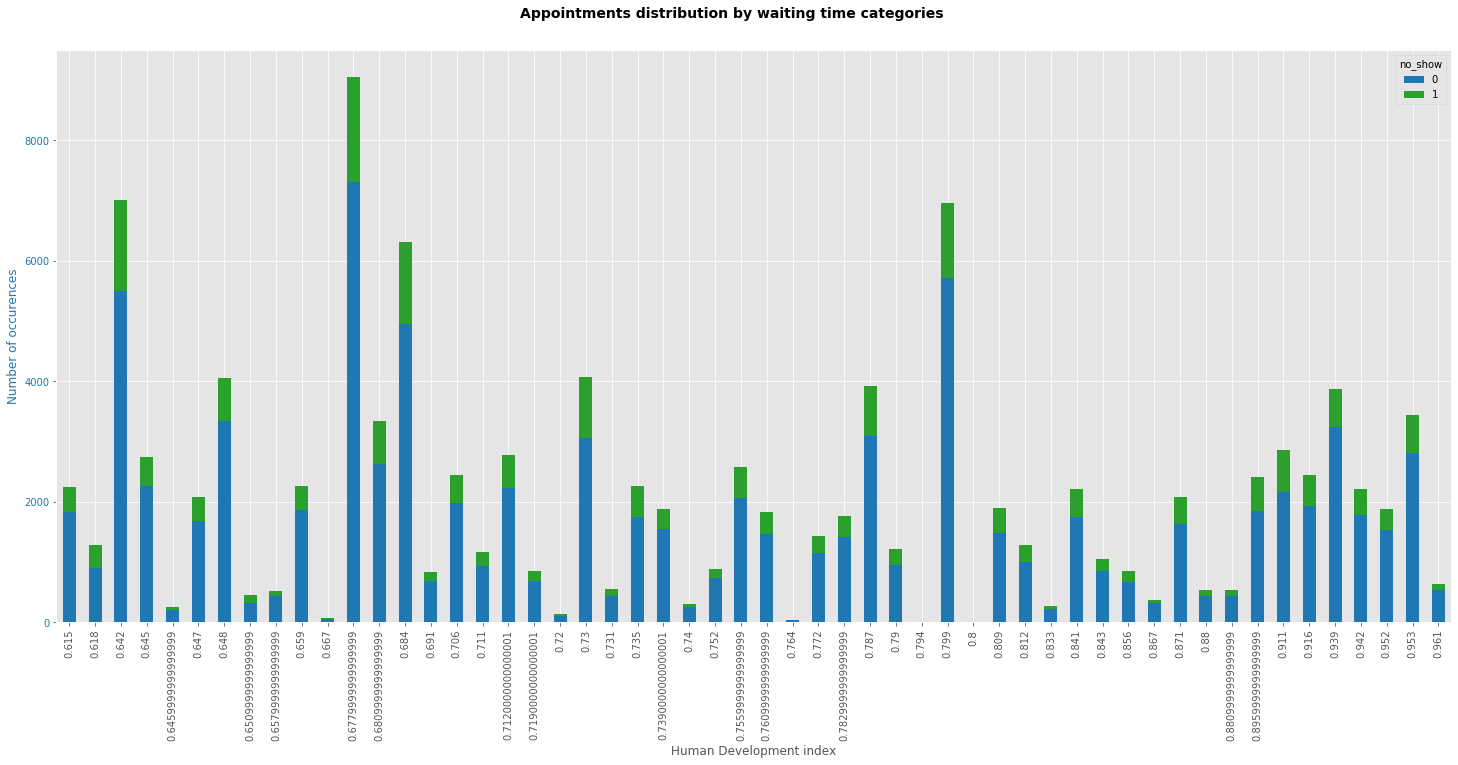

In [62]:
## Setting the graph parameters:
fig1, ax = plt.subplots(figsize=[25,10])  #Defines the graph window size
fig1.subplots_adjust(top=0.92)
plt.suptitle('Appointments distribution by waiting time categories', fontsize=14, fontweight='bold')

colors = ['tab:blue', 'tab:green', 'tab:red']  #Defines the colors to be used

ax.set_ylabel('Number of occurences', color=colors[0], fontsize=12)  #Set the y-axis color and label
ax.tick_params(axis='y', labelcolor=colors[0])

## Plotting the bar chart:
hdi[['hdi', 0, 1]].plot(x='hdi', kind='bar', ax=ax, color=colors[0:2], stacked= True)

ax.set_xlabel('Human Development index', fontsize=12)  #Set the y-axis color and label

plt.show()

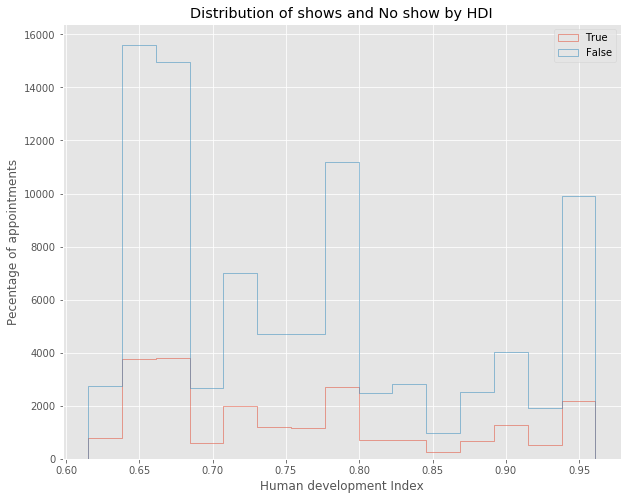

In [63]:
# graphic showing the histogram of data

fig, ax = plt.subplots(figsize=[10,8])
# Plot a histogram of "Weight" for mens_rowing
ax.hist(df[df['no_show']==1]['hdi'], bins=15, histtype='step', label='True', stacked= True)
ax.hist(df[df['no_show']==0]['hdi'], bins=15, histtype='step', label='False', stacked= True)
# ax.hist(df[df['_STATE']==36]['PHYSHLTH'], bins=15, density=True,histtype='step', label='NY')

# Set labels and title
ax.set_xlabel('Human development Index')
ax.set_ylabel('Pecentage of appointments')
ax.set_title("Distribution of shows and No show by HDI")
ax.legend()

plt.show()

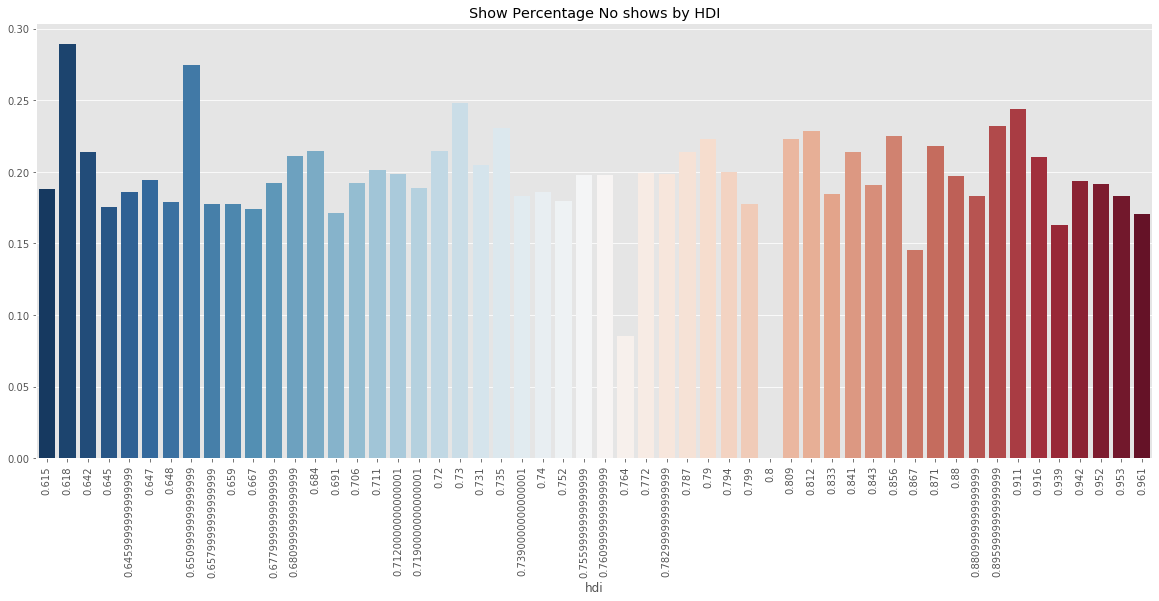

In [72]:
#pecentage of noshw by HDI
plt.subplots(figsize=[20,8])
df_h_ratio = df[df.no_show == 1].groupby(['hdi']).size()/df.groupby(['hdi']).size()
ax = sns.barplot(x=df_h_ratio.index, y=df_h_ratio, palette="RdBu_r")
ax.set_title("Show Percentage No shows by HDI")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### Addititonal Features

In [67]:
df['current_year'] = 2017

In [68]:
df['year_birth'] = df['current_year'] - df['age']

In [69]:
bins = [1890, 1901, 1925, 1946, 1965, 1981, 1997, 2012, 2020]

bins_year_birth = pd.cut(df['year_birth'], bins, include_lowest = False, labels = ('interbellum', 'greatest', 'silent', 'boomer', 'x', 'millennial', 'zoomer', 'alpha'))
df['generation'] = bins_year_birth.cat.as_unordered()

In [70]:
df['at_risk']= np.where(df['hipertension']+df['diabetes']+df['alcoholism'] >= 1,1,0)

### At Risk

Took a closer look at patients we considered at risk, that is two or more diseases and check to see how they relate with our target varible no show

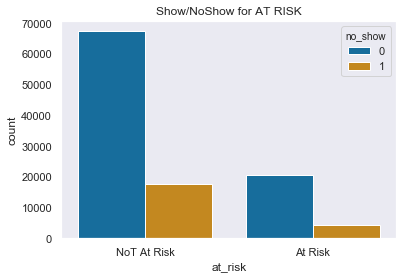

In [202]:
#at risk show/ no show counts
ax = sns.countplot(x=df.at_risk, hue=df.no_show, data=df)
ax.set_title("Show/NoShow for AT RISK")
x_ticks_labels=['NoT At Risk', 'At Risk']
ax.set_xticklabels(x_ticks_labels)
plt.show()


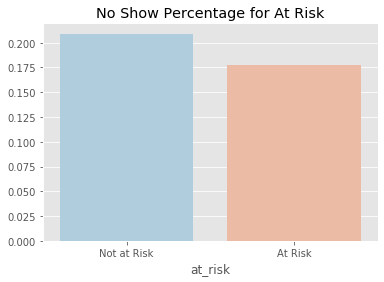

In [73]:
df_risk_ratio = df[df.no_show== 1].groupby(['at_risk']).size()/df.groupby(['at_risk']).size()
ax = sns.barplot(x=df_risk_ratio.index, y=df_risk_ratio, palette="RdBu_r")
ax.set_title("No Show Percentage for At Risk")
x_ticks_labels=['Not at Risk', 'At Risk']
ax.set_xticklabels(x_ticks_labels)
plt.show()

### At Risk STATS Test
-T-Test


NUll hypotesis: That the rate of noshows of at risk population = the rate of no show for not at risk population

Alternate Hypotesis: The rate of no show of people at risk is not equal to the rate of no shows for people at risk 

In [263]:
df_risk_ratio = df[df.no_show== 1].groupby(['at_risk']).size()/df.groupby(['at_risk']).size()
df_risk_ratio

at_risk
0    0.209045
1    0.177712
dtype: float64

In [264]:
df.groupby(['at_risk']).no_show.mean()

at_risk
0    0.209045
1    0.177712
Name: no_show, dtype: float64

In [265]:
show=df[df['no_show']==0]
noshow=df[df['no_show']==1]

In [268]:
import statsmodels.api as sm
import numpy as np
import scipy.stats as stats
stats.ttest_ind(show['at_risk'], noshow['at_risk'])

Ttest_indResult(statistic=10.895289911332352, pvalue=1.2537486156589837e-27)

We can rejct the null hypotesis, there is a significant difference in the rate of noshows for people at risk vs the rate of noshows for people not at risk.

Findings: We find that this infact is an important feature, and we can see that people who are at risk tend to make their appointments more often

### HANDICAP ( handcap *)

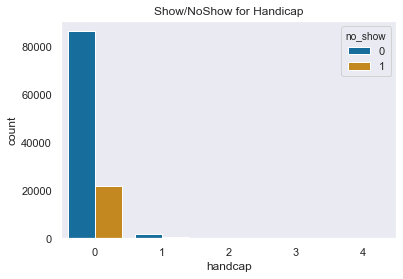

In [207]:
ax = sns.countplot(x=df.handcap, hue=df.no_show, data=df)
ax.set_title("Show/NoShow for Handicap")
plt.show()


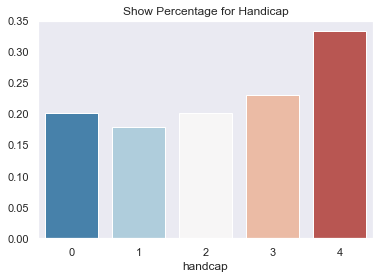

In [208]:
df_ha_ratio = df[df.no_show == 1].groupby(['handcap']).size()/df.groupby(['handcap']).size()
ax = sns.barplot(x=df_ha_ratio.index, y=df_ha_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for Handicap")
plt.show()

In [223]:
df[df.handcap == 4]

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,hdi,day_of_week,waiting_days,waiting_categories,cnt,current_year,year_birth,generation,at_risk
91820,9.251878e+12,5789549,M,2016-06-08 00:00:00+00:00,2016-06-08 00:00:00+00:00,15,DA PENHA,0,0,0,0,4,0,0,0.942,Wednesday,0,same day: 0,1,2017,2002,zoomer,0
98538,4.972463e+14,5760621,M,2016-06-01 00:00:00+00:00,2016-06-03 00:00:00+00:00,19,SÃO PEDRO,0,0,0,0,4,0,0,0.916,Friday,2,short: 1-3,1,2017,1998,zoomer,0
104268,7.581895e+14,5697136,F,2016-05-13 00:00:00+00:00,2016-06-02 00:00:00+00:00,9,ITARARÉ,0,0,0,0,4,1,1,0.730,Thursday,20,month: 16-30,1,2017,2008,zoomer,0


### SMS Received

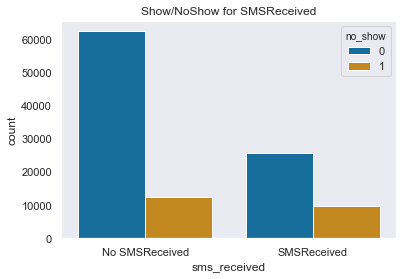

In [209]:
ax = sns.countplot(x=df.sms_received, hue=df.no_show, data=df)
ax.set_title("Show/NoShow for SMSReceived")
x_ticks_labels=['No SMSReceived', 'SMSReceived']
ax.set_xticklabels(x_ticks_labels)
plt.show()

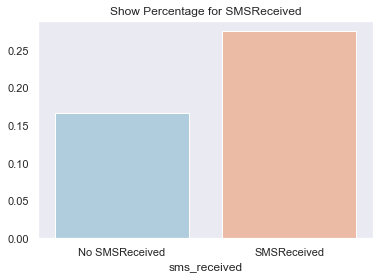

In [210]:
df_s_ratio = df[df.no_show == 1].groupby(['sms_received']).size()/df.groupby(['sms_received']).size()
ax = sns.barplot(x=df_s_ratio.index, y=df_s_ratio, palette="RdBu_r")
ax.set_title("Show Percentage of no shows for SMSReceived")
x_ticks_labels=['No SMSReceived', 'SMSReceived']
ax.set_xticklabels(x_ticks_labels)
plt.show()


In [82]:
#t_test to check the sms_ received no show rates
import statsmodels.api as sm
import numpy as np
import scipy.stats as stats
stats.ttest_ind(show['sms_received'], noshow['sms_received'])

Ttest_indResult(statistic=-42.39668691823939, pvalue=0.0)

findings: SMS recieved feature was counter intuitive, the rate of no shows where significanty more for those who recived SMS, but we councluded that further investigation has to be done on this feature for what it actually means to recieve SMS, do you sign get to sign up for the service? if sowe can say who didnt sign up or not.

### Genereations 

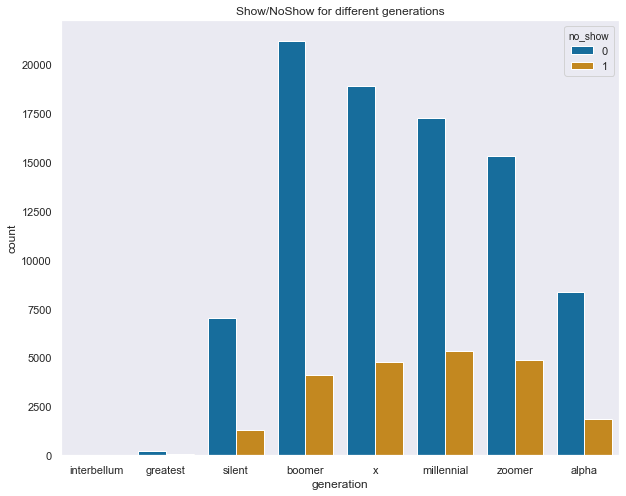

In [214]:
plt.subplots(figsize=[10,8])
ax = sns.countplot(x=df.generation, hue=df.no_show, data=df)
ax.set_title("Show/NoShow for different generations")
# x_ticks_labels=['No SMSReceived', 'SMSReceived']
x_ticks_labels=['interbellum', 'greatest', 'silent', 'boomer', 'x', 'millennial', 'zoomer', 'alpha']
ax.set_xticklabels(x_ticks_labels)
plt.show()

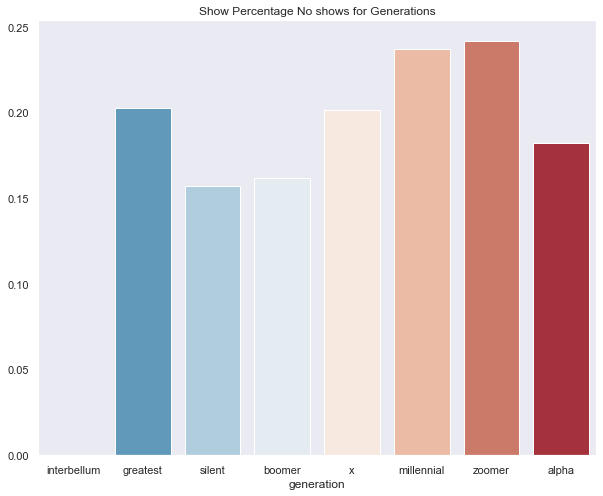

In [217]:
plt.subplots(figsize=[10,8])
df_g_ratio = df[df.no_show == 1].groupby(['generation']).size()/df.groupby(['generation']).size()
ax = sns.barplot(x=df_g_ratio.index, y=df_g_ratio, palette="RdBu_r")
ax.set_title("Show Percentage No shows for Generations")
x_ticks_labels=['interbellum', 'greatest', 'silent', 'boomer', 'x', 'millennial', 'zoomer', 'alpha']
ax.set_xticklabels(x_ticks_labels)
plt.show()

### Chi squared on generation

Null Hypotesis HO: That there is no significant difference in the rate of no- shows accross

In [245]:
dfg1 = df[df['generation'] == 'interbellum']
dfg2 = df[df['generation'] == 'greatest']
dfg3 = df[df['generation'] == 'silent']
dfg4 = df[df['generation'] == 'boomer']
dfg5 = df[df['generation'] == 'x']
dfg6 = df[df['generation'] == 'millennial']
dfg7 = df[df['generation'] == 'zoomer']
dfg8 = df[df['generation'] == 'alpha']

In [ ]:
['interbellum', 'greatest', 'silent', 'boomer', 'x', 'millennial', 'zoomer', 'alpha']

In [257]:

df_g = pd.DataFrame(columns=['greatest', 'silent', 'boomer', 'x', 'millennial', 'zoomer', 'alpha'])

#df_g['interbellum'] = dfg1.groupby('no_show')['no_show'].count()
df_g['greatest'] = dfg2.groupby('no_show')['no_show'].count()
df_g['silent'] = dfg3.groupby('no_show')['no_show'].count()
df_g['boomer'] = dfg4.groupby('no_show')['no_show'].count()
df_g['x'] = dfg5.groupby('no_show')['no_show'].count()
df_g['millennial'] = dfg6.groupby('no_show')['no_show'].count()
df_g['zoomer'] = dfg7.groupby('no_show')['no_show'].count()
df_g['alpha'] = dfg8.groupby('no_show')['no_show'].count()


df_g.head()

,greatest,silent,boomer,x,millennial,zoomer,alpha
no_show,,,,,,,
0,193,7022,21197,18892,17233,15293,8378
1,49,1308,4086,4774,5358,4874,1865


In [258]:
df_g.fillna(value=0, inplace=True)
df_g.reset_index(drop=False, inplace=True)
df_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   no_show     2 non-null      int64
 1   greatest    2 non-null      int64
 2   silent      2 non-null      int64
 3   boomer      2 non-null      int64
 4   x           2 non-null      int64
 5   millennial  2 non-null      int64
 6   zoomer      2 non-null      int64
 7   alpha       2 non-null      int64
dtypes: int64(8)
memory usage: 256.0 bytes


In [259]:
df_g

,no_show,greatest,silent,boomer,x,millennial,zoomer,alpha
0,0,193,7022,21197,18892,17233,15293,8378
1,1,49,1308,4086,4774,5358,4874,1865


In [261]:
from scipy.stats import  chi2_contingency
from scipy.stats import chisquare
from scipy.stats import chi2

stat, p, dof, expected = chi2_contingency(df_g)
print('dof=%d' % dof)
print(expected)
#interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f)' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (regject H0)')
else:
    print('Independent (fail to reject H0)')
#interpret p-value
alpha= 1-prob
print('signigicance=%.3f, p=%.3f,' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else: 
    print('Independent (fail to reject)')

dof=7
[[7.98096324e-01 1.93139310e+02 6.64814238e+03 2.01782694e+04
  1.88877476e+04 1.80297941e+04 1.60952086e+04 8.17490065e+03]
 [2.01903676e-01 4.88606896e+01 1.68185762e+03 5.10473064e+03
  4.77825240e+03 4.56120595e+03 4.07179144e+03 2.06809935e+03]]
probability=0.950, critical=14.067, stat=760.249)
Dependent (regject H0)
signigicance=0.050, p=0.000,
Dependent (reject H0)


significant different in the rates

## NO SHOWS: a look at the no shows data

In [71]:
df3 = df[df.no_show == 1] 

In [160]:
df3.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,hdi,day_of_week,waiting_days,waiting_categories,cnt,current_year,year_birth,generation,at_risk
6,7.336882e+14,5630279,F,2016-04-27 00:00:00+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,0,0,0,1,0.647,Friday,2,short: 1-3,1,2017,1994,millennial,0
7,3.449833e+12,5630575,F,2016-04-27 00:00:00+00:00,2016-04-29 00:00:00+00:00,39,GOIABEIRAS,0,0,0,0,0,0,1,0.647,Friday,2,short: 1-3,1,2017,1978,x,0
11,7.542951e+12,5620163,M,2016-04-26 00:00:00+00:00,2016-04-29 00:00:00+00:00,29,NOVA PALESTINA,0,0,0,0,0,1,1,0.659,Friday,3,short: 1-3,1,2017,1988,millennial,0
17,1.479497e+13,5633460,F,2016-04-28 00:00:00+00:00,2016-04-29 00:00:00+00:00,40,CONQUISTA,1,0,0,0,0,0,1,0.719,Friday,1,short: 1-3,1,2017,1977,x,0
20,6.222575e+14,5626083,F,2016-04-27 00:00:00+00:00,2016-04-29 00:00:00+00:00,30,NOVA PALESTINA,0,0,0,0,0,0,1,0.659,Friday,2,short: 1-3,1,2017,1987,millennial,0


In [176]:
len(df3[df3['generation']=='greatest'])

49

In [175]:
len(df3[df3['generation']=='silent'])

1308

In [177]:
len(df3[df3['generation']=='x'])

4774

### Genereations 

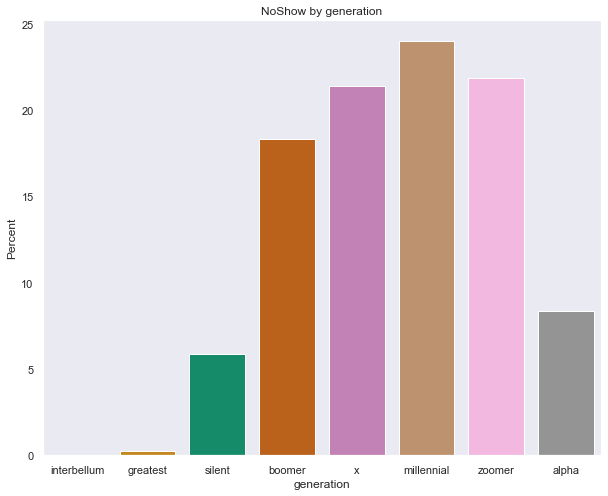

In [179]:
plt.subplots(figsize=[10,8])
ax = sns.barplot(x="generation", y="cnt", data=df3, estimator=lambda x: len(x) / len(df3) * 100)
ax.set(ylabel="Percent")
ax.set_title("NoShow by generation")
x_ticks_labels=['interbellum', 'greatest', 'silent', 'boomer', 'x', 'millennial', 'zoomer', 'alpha']
ax.set_xticklabels(x_ticks_labels)
plt.show()

In [181]:
week_key

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

Text(0.5, 1.0, 'NoShow by Days of the week')

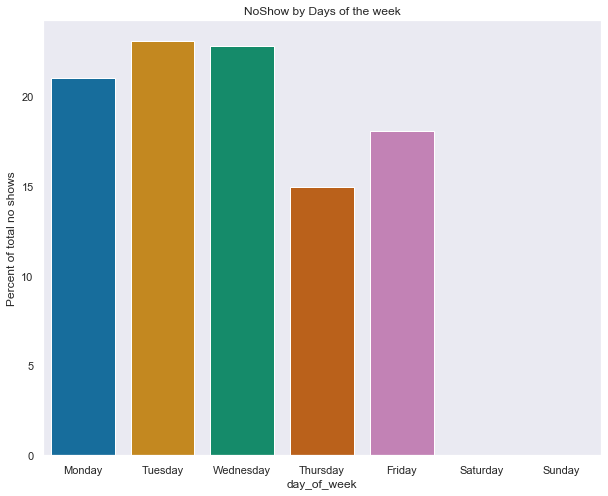

In [212]:
plt.subplots(figsize=[10,8])
week_key=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.barplot(x="day_of_week", y="cnt", data=df3, estimator=lambda x: len(x) / len(df3) * 100, order=week_key)
ax.set(ylabel="Percent of total no shows")
ax.set_title("NoShow by Days of the week")


Text(0.5, 1.0, 'Distribution of hdi of No show population')

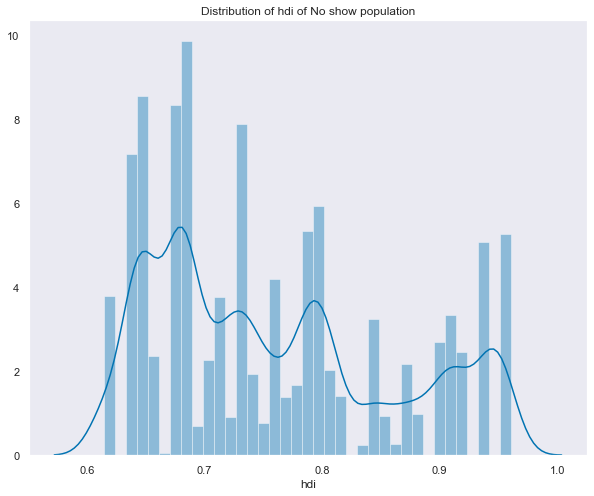

In [185]:
plt.subplots(figsize=[10,8])
ax= sns.distplot(df3['hdi'])
# ax.set(ylabel="Percent of total no shows")
ax.set_title("Distribution of hdi of No show population")


Text(0.5, 1.0, 'Distribution of AGE of No show population')

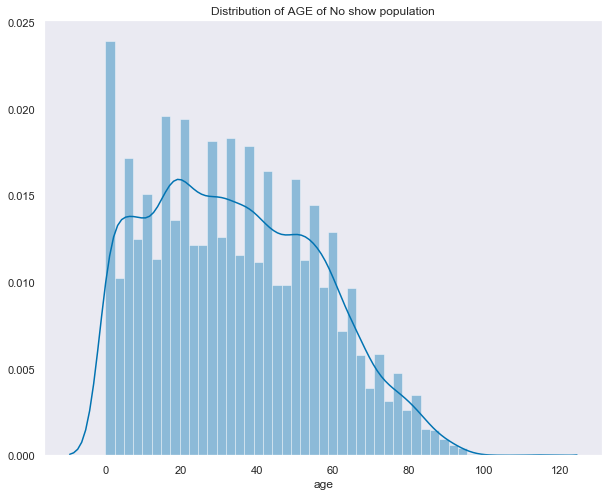

In [186]:
plt.subplots(figsize=[10,8])
ax= sns.distplot(df3['age'])
# ax.set(ylabel="Percent of total no shows")
ax.set_title("Distribution of AGE of No show population")


Text(0.5, 1.0, 'No-Shows by Waiting categoies')

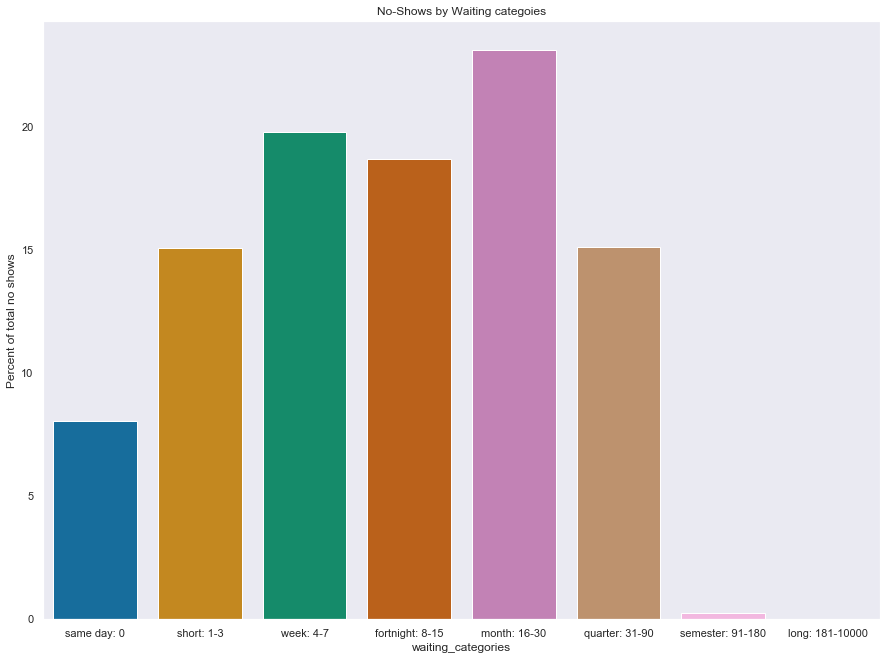

In [189]:
plt.subplots(figsize=[15,11])
# week_key=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.barplot(x="waiting_categories", y="cnt", data=df3, estimator=lambda x: len(x) / len(df3) * 100)
ax.set(ylabel="Percent of total no shows")
ax.set_title("No-Shows by Waiting categoies")


Text(0.5, 1.0, 'Distribution of waiting days of the No show population')

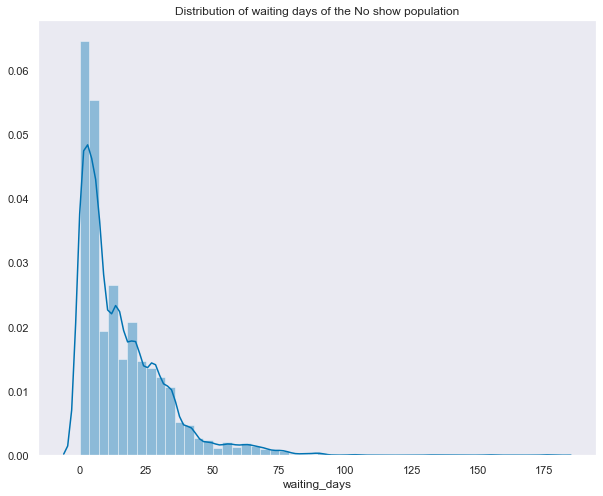

In [190]:
plt.subplots(figsize=[10,8])
ax= sns.distplot(df3['waiting_days'])
# ax.set(ylabel="Percent of total no shows")
ax.set_title("Distribution of waiting days of the No show population")
